In [1]:
import pandas as pd
import numpy as np
import os
import math

Dataset obtained from google's Global Knowledge Graph SQL query
<details>
<summary>
  <span style="color:#55b4a1">
    <strong>
      Click to expand SQL Query
    </strong>
  </span>
</summary>

SELECT 
    DATE,
    SourceCommonName,
    DocumentIdentifier,
    V2Themes,
    SAFE_CAST(SPLIT(V2Tone, ',')[SAFE_OFFSET(0)] AS FLOAT64) AS OverallScore,
    SAFE_CAST(SPLIT(V2Tone, ',')[SAFE_OFFSET(1)] AS FLOAT64) AS PositiveScore,
    SAFE_CAST(SPLIT(V2Tone, ',')[SAFE_OFFSET(2)] AS FLOAT64) AS NegativeScore,
    SAFE_CAST(SPLIT(V2Tone, ',')[SAFE_OFFSET(3)] AS FLOAT64) AS PolarityScore,
    SAFE_CAST(SPLIT(V2Tone, ',')[SAFE_OFFSET(4)] AS FLOAT64) AS ActivenessScore

FROM `gdelt-bq.gdeltv2.gkg_partitioned`
WHERE
_PARTITIONTIME >= TIMESTAMP('2024-01-01')
    AND (
      LOWER(Themes) LIKE '%btc%'
      OR LOWER(Themes) LIKE '%bitcoin%'
      OR LOWER(Themes) LIKE '%cryptocurrency%'
      OR LOWER(Themes) LIKE '%crypto%'
    )
</details>


In [2]:
# Load the dataset

folder_path = './GDELT_Bitcoin_Sentiment/'

df_list = []
months = ['January', 'February', 'March', "April", 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for month in months:
    print(f"Processing csv file for {month}")
    sentiment_file_path = os.path.join(folder_path, f"12 March GDELTS - {month}.csv") 
    df = pd.read_csv(sentiment_file_path)
    if 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d%H%M%S', errors='coerce')
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df = df.sort_values(by='DATE')

Processing csv file for January
Processing csv file for February
Processing csv file for March
Processing csv file for April
Processing csv file for May
Processing csv file for June
Processing csv file for July
Processing csv file for August
Processing csv file for September
Processing csv file for October
Processing csv file for November
Processing csv file for December


In [3]:
df

,DATE,SourceCommonName,DocumentIdentifier,OverallScore,PositiveScore,NegativeScore,PolarityScore,ActivenessScore
0,2024-01-01 00:00:00,barrons.com,https://www.barrons.com/market-data/bonds/ambm...,-3.947368,0.000000,3.947368,3.947368,19.956140
1,2024-01-01 00:00:00,cointelegraph.com,https://cointelegraph.com/news/cross-chain-pro...,-1.212121,1.515152,2.727273,4.242424,25.454545
2,2024-01-01 00:00:00,cointelegraph.com,https://cointelegraph.com/news/bitcoin-price-s...,-0.216606,2.166065,2.382671,4.548736,27.581227
3,2024-01-01 00:00:00,ettvamerica.com,https://www.ettvamerica.com/News/Article?i=252769,-5.185185,2.222222,7.407407,9.629630,24.296296
4,2024-01-01 00:15:00,forbes.com,https://www.forbes.com/sites/digital-assets/20...,0.892857,2.551020,1.658163,4.209184,22.704082
...,...,...,...,...,...,...,...,...
674208,2025-03-05 11:45:00,news.day.az,https://news.day.az/hitech/1734636.html,2.293578,4.587156,2.293578,6.880734,17.431193
674207,2025-03-05 11:45:00,variety1065.com,https://variety1065.com/html/79e12999791.html,2.989130,5.163043,2.173913,7.336957,24.728261
674222,2025-03-05 11:45:00,baotintuc.vn,https://baotintuc.vn/thoi-su/thu-truong-bo-tai...,2.564103,4.273504,1.709402,5.982906,26.923077
674214,2025-03-05 11:45:00,vietbao.vn,https://vietbao.vn/viet-nam-sap-co-san-giao-di...,0.694444,2.430556,1.736111,4.166667,26.388889


In [4]:
def compute_decayed_sentiment(df, lambda_decay=0.1, composite_func=None, date_column='DATE'):
    """
    Compute a decaying sentiment indicator from a dataframe of news events.
    
    Each event contributes a composite sentiment score that decays exponentially over time.
    The function returns two new columns:
      - 'DecayedSentiment': the cumulative decayed sentiment.
      - 'NormalizedDecayedSentiment': the decayed sentiment normalized by the decayed event weights.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing news events with at least a date column and sentiment score(s).
    lambda_decay : float, default 0.1
        Decay parameter controlling how quickly an event’s influence fades.
    composite_func : function, optional
        A function that takes a row (a pandas Series) and returns a composite sentiment score.
        If None, the function defaults to using the 'OverallScore' column.
    date_column : str, default 'DATE'
        Name of the column in df that contains the timestamp of each news event.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with two additional columns:
         - 'DecayedSentiment'
         - 'NormalizedDecayedSentiment'
    """
    
    # If no composite function is provided, use the 'OverallScore' column.
    if composite_func is None:
        composite_func = lambda row: row['OverallScore']
    
    decayed_sentiments = []        # To store the cumulative sentiment S(t)
    normalized_sentiments = []     # To store the normalized sentiment score
    
    # Initialize cumulative sentiment and weight.
    S = 0.0      # Cumulative decayed sentiment
    W = 0.0      # Cumulative decayed weight (each event counts as 1 when it arrives)
    last_time = None
    
    # Iterate through each news event.
    for _, row in df.iterrows():
        current_time = row[date_column]
        # Compute the composite sentiment for the current event.
        s = composite_func(row)
        
        if last_time is None:
            # For the first event, initialize S and weight.
            S = s
            W = 1.0
        else:
            # Compute time difference (in seconds) from the last event.
            delta_t = (current_time - last_time).total_seconds()
            decay_factor = np.exp(-lambda_decay * delta_t)
            
            # Decay the previous cumulative sentiment and weight.
            S = S * decay_factor + s
            W = W * decay_factor + 1.0
        
        # Compute the normalized sentiment as a weighted average.
        normalized = S / W if W != 0 else S
        
        decayed_sentiments.append(S)
        normalized_sentiments.append(normalized)
        last_time = current_time  # Update the last event time.
    
    # Add the new computed columns to the dataframe.
    df['DecayedSentiment'] = decayed_sentiments
    df['NormalizedDecayedSentiment'] = normalized_sentiments
    
    return df


In [16]:
df['ActivenessScore'].min()

0.0

In [5]:
custom_composite = lambda row: row['OverallScore'] * (1 / np.log1p(row['ActivenessScore'] + 1))

# Compute the decayed sentiment (you can use custom_composite or leave it as None to use OverallScore).
result_df = compute_decayed_sentiment(df, lambda_decay=0.1, composite_func=custom_composite) #

df['DecayedSentiment'] = 100 * np.tanh(df['DecayedSentiment'] / 100)
df['NormalizedDecayedSentiment'] = 100 * np.tanh(df['NormalizedDecayedSentiment'] / 100)

# Display the results.
result_df[['DATE', 'OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']]

,DATE,OverallScore,DecayedSentiment,NormalizedDecayedSentiment
0,2024-01-01 00:00:00,-3.947368,-1.277790,-1.277790
1,2024-01-01 00:00:00,-1.212121,-1.643632,-0.821871
2,2024-01-01 00:00:00,-0.216606,-1.707563,-0.569237
3,2024-01-01 00:00:00,-5.185185,-3.292500,-0.823404
4,2024-01-01 00:15:00,0.892857,0.278411,0.278411
...,...,...,...,...
674208,2025-03-05 11:45:00,2.293578,-0.173527,-0.013348
674207,2025-03-05 11:45:00,2.989130,0.736193,0.052586
674222,2025-03-05 11:45:00,2.564103,1.498168,0.099885
674214,2025-03-05 11:45:00,0.694444,1.705659,0.106614


In [7]:
smooth_score_path = os.path.join(folder_path, "GDELTS_smooth_score.csv")
result_df.to_csv(smooth_score_path)

## plotty

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

folder_path = '../data/GDELT_Bitcoin_Sentiment/'

# File paths
file1 = os.path.join(folder_path, "GDELTS_smooth_score.csv_part1.csv")
file2 = os.path.join(folder_path,"GDELTS_smooth_score.csv_part2.csv")

# Read CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)


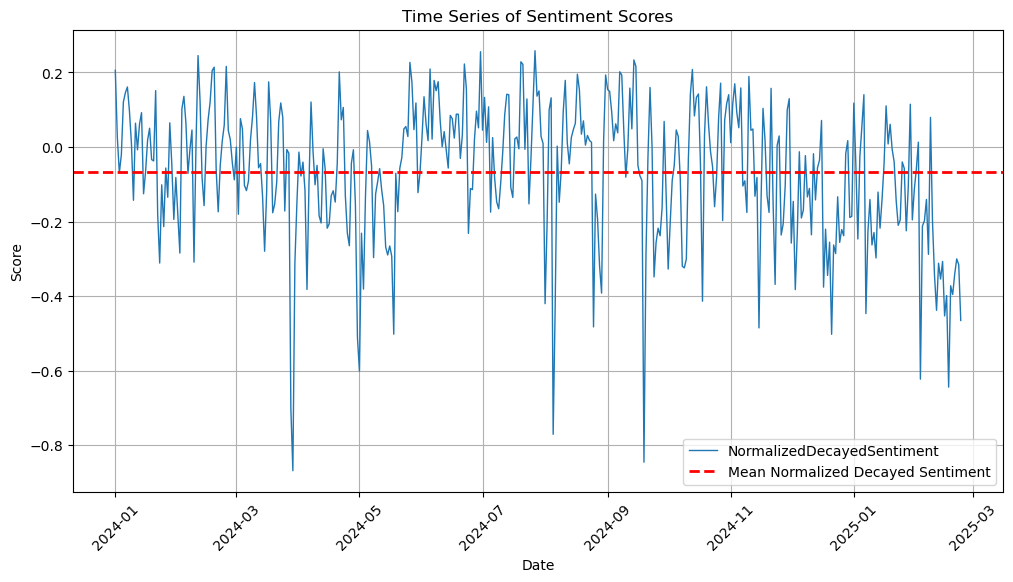

In [21]:
# Merge the two datasets
df = pd.concat([df1, df2])

# Select only specific columns
df = df[['DATE', 'OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']]

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Ensure numeric columns are actually numeric
numeric_cols = ['OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Sort by date to ensure correct time series plotting
df = df.sort_values(by='DATE')

start_date = df['DATE'].min()
end_date = start_date + pd.Timedelta(weeks=60)
df_filtered = df[(df['DATE'] >= start_date) & (df['DATE'] < end_date)]

# Aggregate by day: Compute the daily mean for each sentiment score
df_daily = df_filtered.resample('D', on='DATE').mean().reset_index()

# Calculate the mean of 'NormalizedDecayedSentiment' for the first x weeks
mean_normalized_sentiment = df_daily['NormalizedDecayedSentiment'].mean()

# Plot the time series with 3 lines
plt.figure(figsize=(12, 6))
plt.plot(df_daily['DATE'], df_daily['NormalizedDecayedSentiment'], label='NormalizedDecayedSentiment', linewidth=1)
plt.axhline(y=mean_normalized_sentiment, color='red', linestyle='--', linewidth=2, label="Mean Normalized Decayed Sentiment")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Score")
plt.title("Time Series of Sentiment Scores")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


## Using Ethan's Script for score smoothing

In [22]:
df = df.rename(columns={'DATE': 'created_at'})

In [23]:
df

,created_at,OverallScore,DecayedSentiment,NormalizedDecayedSentiment
0,2024-01-01 00:00:00,-3.947368,-1.277790,-1.277790
1,2024-01-01 00:00:00,-1.212121,-1.643632,-0.821871
2,2024-01-01 00:00:00,-0.216606,-1.707563,-0.569237
3,2024-01-01 00:00:00,-5.185185,-3.292500,-0.823404
4,2024-01-01 00:15:00,0.892857,0.278411,0.278411
...,...,...,...,...
337096,2025-03-05 11:45:00,2.551020,-0.024468,-0.012234
337095,2025-03-05 11:45:00,-2.301790,-0.761542,-0.761542
337110,2025-03-05 11:45:00,0.694444,1.705659,0.106614
337102,2025-03-05 11:45:00,-3.296703,-1.069446,-0.133686


C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\3699629246.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df['created_at'].min().floor('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\3699629246.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df['created_at'].max().ceil('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\3699629246.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                     smoothed_sentiment
2024-01-01 00:00:00          -10.561281
2024-01-01 01:00:00           24.403801
2024-01-01 02:00:00           81.390333
2024-01-01 03:00:00          149.256078
2024-01-01 04:00:00          142.824226


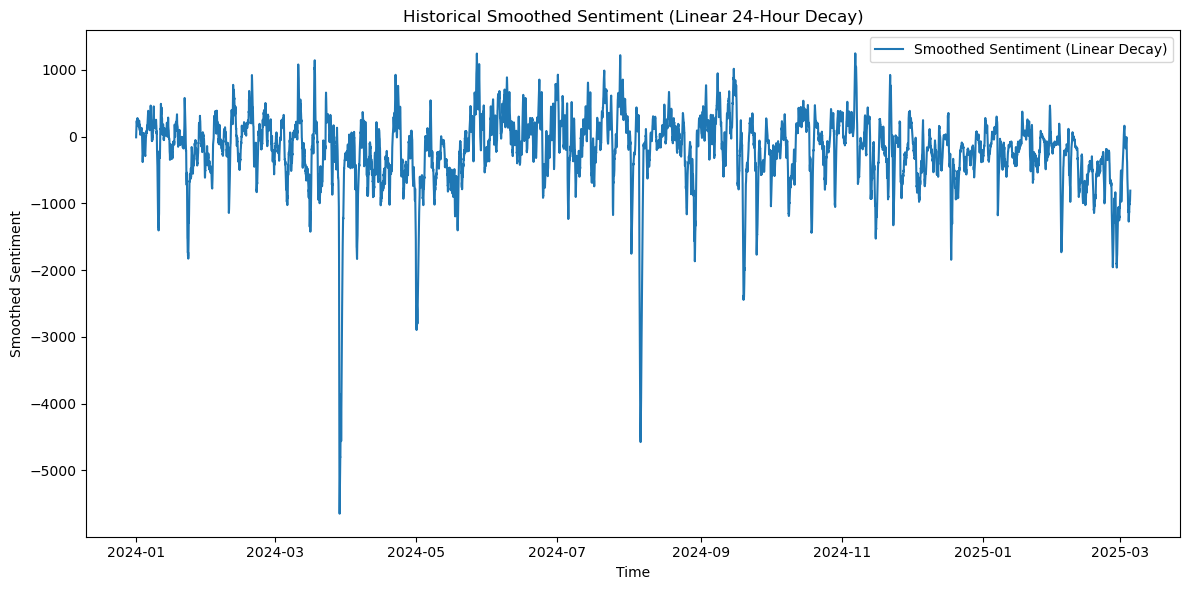

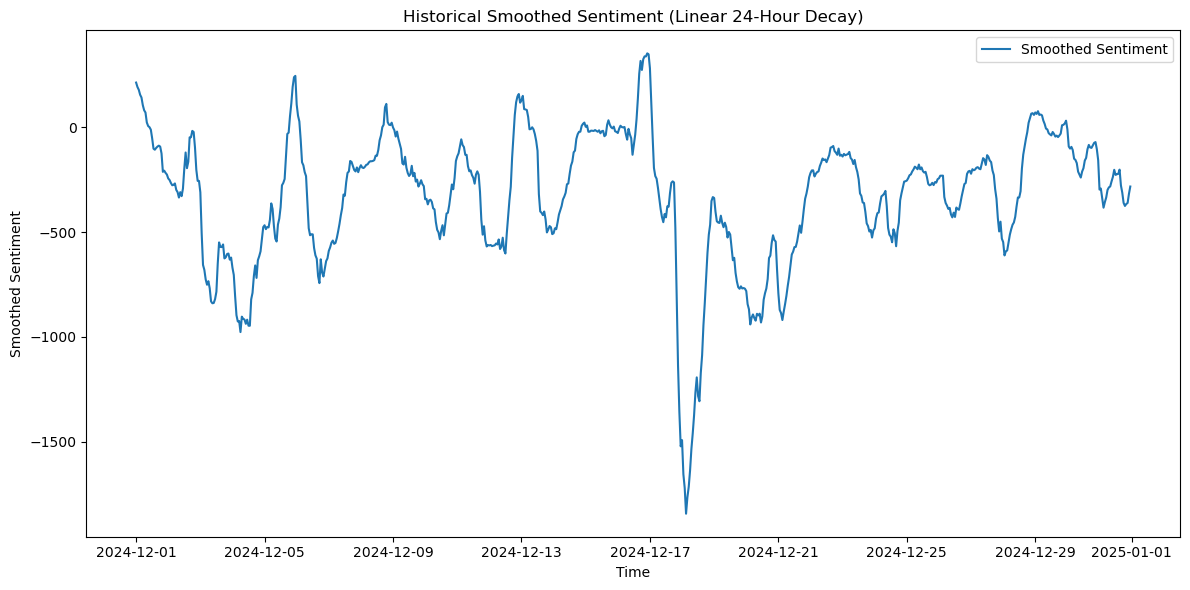

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

# Define the start and end time for the analysis (rounded to the nearest hour)
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')

# Create an hourly date range
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_linear(t):
    """
    Compute the smoothed sentiment at time t as the weighted sum of sentiment scores
    in the past 24 hours. Each news event decays linearly: its weight is 
    1 - (time difference in hours)/24.
    """
    # Define the 24-hour window for events affecting time t
    window_start = t - pd.Timedelta(hours=24)
    
    # Filter news events that occurred in the last 24 hours (excluding events after t)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    
    if df_window.empty:
        return 0.0  # No news, no sentiment effect.
    
    # Calculate the time difference (in hours) between t and each news event
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Linear decay: weight = 1 - (difference/24)
    weights = 1 - (time_diffs / 24)
    weights = weights.clip(lower=0)  # Ensure no negative weights
    
    # Compute the weighted sentiment sum
    weighted_sentiment = (df_window['OverallScore'] * weights).sum()
    return weighted_sentiment

# Apply the function to each timestamp in the hourly index
smoothed_sentiments = [compute_smoothed_sentiment_linear(t) for t in hourly_index]

# Create a DataFrame with the results
df_sentiment = pd.DataFrame({'smoothed_sentiment': smoothed_sentiments}, index=hourly_index)

# Display the first few rows
print(df_sentiment.head())

# Optionally, plot the smoothed sentiment time series 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment'], label='Smoothed Sentiment (Linear Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\742560217.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                     smoothed_sentiment  smoothed_sentiment_weibull
2024-01-01 00:00:00          -10.561281                    0.000000
2024-01-01 01:00:00           24.403801                   -0.547465
2024-01-01 02:00:00           81.390333                   15.977209
2024-01-01 03:00:00          149.256078                   56.542854
2024-01-01 04:00:00          142.824226                  106.318283


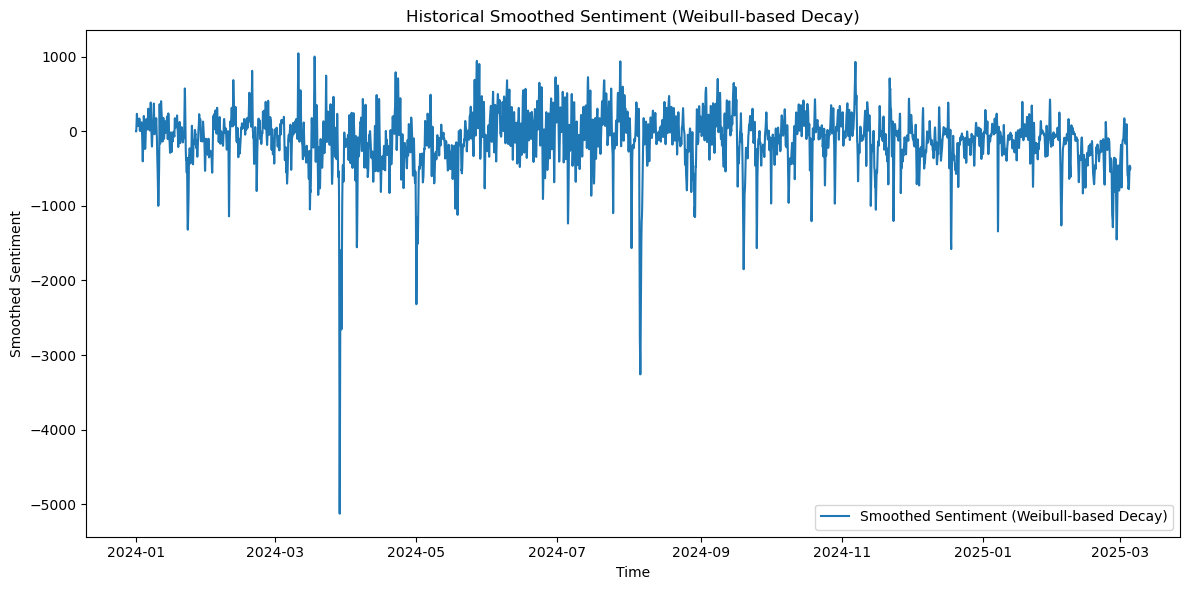

In [6]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# Parameters for the Weibull distribution
k = 2.0       # shape parameter (k > 1 gives a peak)
lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# Determine the mode (peak) of the Weibull PDF and compute its maximum value
x_mode = lam * ((k - 1) / k) ** (1 / k)
max_weight = weibull_min.pdf(x_mode, k, scale=lam)

def weight_function(x):
    """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k, scale=lam) / max_weight

# Create an hourly date range for the smoothed sentiment time series
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_weibull(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last 48 hours.
    """
    # Consider news events from the past 48 hours
    window_start = t - pd.Timedelta(hours=48)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Compute elapsed time in hours from each news event to time t
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Calculate weights for each news event using the Weibull function
    weights = time_diffs.apply(weight_function)
    # Compute the weighted sum of sentiment scores
    weighted_sentiment = (df_window['OverallScore'] * weights).sum()
    return weighted_sentiment

# Compute the smoothed sentiment for each hour in the time series
smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
df_sentiment

,smoothed_sentiment,smoothed_sentiment_weibull
2024-01-01 00:00:00,-10.561281,0.000000
2024-01-01 01:00:00,24.403801,-0.547465
2024-01-01 02:00:00,81.390333,15.977209
2024-01-01 03:00:00,149.256078,56.542854
2024-01-01 04:00:00,142.824226,106.318283
...,...,...
2025-03-05 08:00:00,-969.584766,-482.226524
2025-03-05 09:00:00,-963.660262,-500.983863
2025-03-05 10:00:00,-893.485247,-511.361227
2025-03-05 11:00:00,-881.780526,-504.326207


In [11]:
df

,created_at,OverallScore,DecayedSentiment,NormalizedDecayedSentiment
0,2024-01-01 00:00:00,-3.947368,-1.277790,-1.277790
1,2024-01-01 00:00:00,-1.212121,-1.643632,-0.821871
2,2024-01-01 00:00:00,-0.216606,-1.707563,-0.569237
3,2024-01-01 00:00:00,-5.185185,-3.292500,-0.823404
4,2024-01-01 00:15:00,0.892857,0.278411,0.278411
...,...,...,...,...
337096,2025-03-05 11:45:00,2.551020,-0.024468,-0.012234
337095,2025-03-05 11:45:00,-2.301790,-0.761542,-0.761542
337110,2025-03-05 11:45:00,0.694444,1.705659,0.106614
337102,2025-03-05 11:45:00,-3.296703,-1.069446,-0.133686


In [ ]:
# Add the weibull and linear sentiment to GDELT Data

df['created_at'] = pd.to_datetime(df['created_at'])
df = df.set_index('created_at')
df = df.join(df_sentiment)


                     OverallScore  DecayedSentiment  \
2024-01-01 00:00:00     -3.947368         -1.277790   
2024-01-01 00:00:00     -1.212121         -1.643632   
2024-01-01 00:00:00     -0.216606         -1.707563   
2024-01-01 00:00:00     -5.185185         -3.292500   
2024-01-01 00:15:00      0.892857          0.278411   

                     NormalizedDecayedSentiment  smoothed_sentiment  \
2024-01-01 00:00:00                   -1.277790          -10.561281   
2024-01-01 00:00:00                   -0.821871          -10.561281   
2024-01-01 00:00:00                   -0.569237          -10.561281   
2024-01-01 00:00:00                   -0.823404          -10.561281   
2024-01-01 00:15:00                    0.278411                 NaN   

                     smoothed_sentiment_weibull  
2024-01-01 00:00:00                         0.0  
2024-01-01 00:00:00                         0.0  
2024-01-01 00:00:00                         0.0  
2024-01-01 00:00:00                       

In [14]:
df

,OverallScore,DecayedSentiment,NormalizedDecayedSentiment,smoothed_sentiment,smoothed_sentiment_weibull
2024-01-01 00:00:00,-3.947368,-1.277790,-1.277790,-10.561281,0.0
2024-01-01 00:00:00,-1.212121,-1.643632,-0.821871,-10.561281,0.0
2024-01-01 00:00:00,-0.216606,-1.707563,-0.569237,-10.561281,0.0
2024-01-01 00:00:00,-5.185185,-3.292500,-0.823404,-10.561281,0.0
2024-01-01 00:15:00,0.892857,0.278411,0.278411,NaN,NaN
...,...,...,...,...,...
2025-03-05 11:45:00,2.551020,-0.024468,-0.012234,NaN,NaN
2025-03-05 11:45:00,-2.301790,-0.761542,-0.761542,NaN,NaN
2025-03-05 11:45:00,0.694444,1.705659,0.106614,NaN,NaN
2025-03-05 11:45:00,-3.296703,-1.069446,-0.133686,NaN,NaN


In [ ]:
mid_point = len(df) // 2
df_part1 = df.iloc[:mid_point]
df_part2 = df.iloc[mid_point:]

GDELT_with_sentiment_path_part1 = os.path.join(folder_path, "GDELT_with_4sentiments_minute_resolution_part1.csv")
GDELT_with_sentiment_path_part2 = os.path.join(folder_path, "GDELT_with_4sentiments_minute_resolution_part2.csv")

df_part1.to_csv(GDELT_with_sentiment_path_part1)
df_part2.to_csv(GDELT_with_sentiment_path_part2)

In [22]:
df_hour

,smoothed_sentiment,smoothed_sentiment_weibull
2024-01-01 00:00:00,-10.561281,0.000000
2024-01-01 01:00:00,24.403801,-0.547465
2024-01-01 02:00:00,81.390333,15.977209
2024-01-01 03:00:00,149.256078,56.542854
2024-01-01 04:00:00,142.824226,106.318283
...,...,...
2025-03-05 07:00:00,-982.982554,-467.002766
2025-03-05 08:00:00,-969.584766,-482.226524
2025-03-05 09:00:00,-963.660262,-500.983863
2025-03-05 10:00:00,-893.485247,-511.361227


In [19]:
df_hour = df.copy()
df_hour = df_hour[['smoothed_sentiment', 'smoothed_sentiment_weibull']]

df_hour = df_hour.dropna(subset=['smoothed_sentiment', 'smoothed_sentiment_weibull'])

In [21]:
df_hour = df_hour[~df_hour.index.duplicated(keep='first')]

In [23]:
mid_point = len(df) // 2
df_part1 = df_hour.iloc[:mid_point]
df_part2 = df_hour.iloc[mid_point:]

GDELT_with_sentiment_path_part1 = os.path.join(folder_path, "GDELT_with_4sentiments_hour_resolution_part1.csv")
GDELT_with_sentiment_path_part2 = os.path.join(folder_path, "GDELT_with_4sentiments_hour_resolution_part2.csv")

df_part1.to_csv(GDELT_with_sentiment_path_part1)
df_part2.to_csv(GDELT_with_sentiment_path_part2)

## 27th March data top up

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os

folder_path = '../data/GDELT_Bitcoin_Sentiment/'

# File paths
file1 = os.path.join(folder_path, "GDELTS_smooth_score.csv_part1.csv")
file2 = os.path.join(folder_path,"GDELTS_smooth_score.csv_part2.csv")

# Read CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Merge the two datasets
df = pd.concat([df1, df2])

# Select only specific columns
df = df[['DATE', 'OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']]

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Ensure numeric columns are actually numeric
numeric_cols = ['OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Sort by date to ensure correct time series plotting
df = df.sort_values(by='DATE')
df.rename(columns={'DATE': 'created_at', 'OverallScore': 'sentiment_score'}, inplace=True)



In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 674224 entries, 0 to 337111
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   created_at                  674224 non-null  datetime64[ns]
 1   sentiment_score             674224 non-null  float64       
 2   DecayedSentiment            674224 non-null  float64       
 3   NormalizedDecayedSentiment  674224 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 25.7 MB


In [11]:
df

,created_at,sentiment_score,DecayedSentiment,NormalizedDecayedSentiment
0,2024-01-01 00:00:00,-3.947368,-1.277790,-1.277790
1,2024-01-01 00:00:00,-1.212121,-1.643632,-0.821871
2,2024-01-01 00:00:00,-0.216606,-1.707563,-0.569237
3,2024-01-01 00:00:00,-5.185185,-3.292500,-0.823404
4,2024-01-01 00:15:00,0.892857,0.278411,0.278411
...,...,...,...,...
337096,2025-03-05 11:45:00,2.551020,-0.024468,-0.012234
337095,2025-03-05 11:45:00,-2.301790,-0.761542,-0.761542
337110,2025-03-05 11:45:00,0.694444,1.705659,0.106614
337102,2025-03-05 11:45:00,-3.296703,-1.069446,-0.133686


In [26]:
GDELT_raw_file3 = os.path.join(folder_path,"GDELTS_Raw_5thMar_to_27thMar.csv")

# Read CSV files
df3_raw = pd.read_csv(GDELT_raw_file3)

In [27]:
GDELT_raw_file4 = os.path.join(folder_path,"GDELTS_Raw_27thMar_to_04thApr.csv")

# Read CSV files
df4_raw = pd.read_csv(GDELT_raw_file4)

In [6]:
df3_raw

,DATE,SourceCommonName,DocumentIdentifier,V2Themes,OverallScore,PositiveScore,NegativeScore,PolarityScore,ActivenessScore
0,20250309013000,edaily.co.kr,https://www.edaily.co.kr/News/Read?newsId=0130...,"WB_698_TRADE,377;WB_698_TRADE,776;EPU_POLICY_W...",-3.773585,0.628931,4.402516,5.031447,31.446541
1,20250309013000,news.mail.ru,https://news.mail.ru/incident/65194575/,"EPU_ECONOMY_HISTORIC,929;SECURITY_SERVICES,229...",-6.547619,0.000000,6.547619,6.547619,21.428571
2,20250309013000,eastmoney.com,https://finance.eastmoney.com/a/20250309334043...,"GENERAL_GOVERNMENT,1045;GENERAL_GOVERNMENT,119...",0.917431,3.486239,2.568807,6.055046,28.073394
3,20250309013000,stcn.com,http://www.stcn.com/article/detail/1571059.html,"TAX_FNCACT_CANDIDATES,3523;LEGISLATION,1419;LE...",0.743494,3.345725,2.602230,5.947955,28.066914
4,20250309011500,163.com,https://www.163.com/dy/article/JQ6Q4637053469R...,"ARMEDCONFLICT,1368;EPU_CATS_NATIONAL_SECURITY,...",0.743494,3.345725,2.602230,5.947955,28.066914
...,...,...,...,...,...,...,...,...,...
23484,20250313084500,dailypolitical.com,https://www.dailypolitical.com/2025/03/13/avan...,"TAX_ECON_PRICE,2036;TAX_WORLDMAMMALS_BEAR,1247...",4.968944,5.383023,0.414079,5.797101,22.360248
23485,20250313084500,biztoc.com,https://biztoc.com/x/ae676023dd4c9168,"CRISISLEX_CRISISLEXREC,98;ECON_BITCOIN,25;",-8.333333,0.000000,8.333333,8.333333,16.666667
23486,20250313084500,asiaone.com,https://www.asiaone.com/world/us-request-india...,"ARREST,61;ARREST,785;ARREST,1349;SOC_GENERALCR...",-6.293706,1.748252,8.041958,9.790210,21.328671
23487,20250313084500,manilatimes.net,https://www.manilatimes.net/2025/03/13/tmt-new...,"EDUCATION,505;TAX_FNCACT_INVESTOR,2049;TAX_FNC...",2.292769,3.174603,0.881834,4.056437,16.049383


In [6]:
df3_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23489 entries, 0 to 23488
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATE                23489 non-null  int64  
 1   SourceCommonName    23489 non-null  object 
 2   DocumentIdentifier  23489 non-null  object 
 3   V2Themes            23489 non-null  object 
 4   OverallScore        23489 non-null  float64
 5   PositiveScore       23489 non-null  float64
 6   NegativeScore       23489 non-null  float64
 7   PolarityScore       23489 non-null  float64
 8   ActivenessScore     23489 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.6+ MB


In [28]:
df3_raw_copy = df3_raw.copy()
# Convert DATE column to datetime format
df3_raw_copy['DATE'] = pd.to_datetime(df3_raw_copy['DATE'], format='%Y%m%d%H%M%S')
df3_raw_copy.sort_values(by='DATE', inplace = True)
# Rename DATE column to created_at
df3_raw_copy.rename(columns={'DATE': 'created_at', 'OverallScore': 'sentiment_score'}, inplace=True)
df3_raw_copy = df3_raw_copy[['created_at', 'sentiment_score']]
df3_raw_copy

,created_at,sentiment_score
13685,2025-03-05 00:00:00,0.417101
13713,2025-03-05 00:00:00,-6.535948
13712,2025-03-05 00:00:00,2.334630
13687,2025-03-05 00:00:00,0.000000
13688,2025-03-05 00:00:00,-4.075235
...,...,...
1216,2025-03-27 23:30:00,-3.281027
1217,2025-03-27 23:30:00,-3.281027
1218,2025-03-27 23:30:00,-2.860061
236,2025-03-27 23:45:00,-5.633803


In [29]:
df4_raw_copy = df4_raw.copy()
# Convert DATE column to datetime format
df4_raw_copy['DATE'] = pd.to_datetime(df4_raw_copy['DATE'], format='%Y%m%d%H%M%S')
df4_raw_copy.sort_values(by='DATE', inplace = True)
# Rename DATE column to created_at
df4_raw_copy.rename(columns={'DATE': 'created_at', 'OverallScore': 'sentiment_score'}, inplace=True)
df4_raw_copy = df4_raw_copy[['created_at', 'sentiment_score']]
df4_raw_copy

,created_at,sentiment_score
12909,2025-03-13 00:00:00,-1.050081
12910,2025-03-13 00:00:00,3.992740
12911,2025-03-13 00:00:00,-1.812689
12912,2025-03-13 00:00:00,-0.347222
12913,2025-03-13 00:15:00,-8.012821
...,...,...
81,2025-04-04 03:00:00,-2.684564
120,2025-04-04 03:00:00,-6.060606
78,2025-04-04 03:00:00,-2.439024
82,2025-04-04 03:15:00,5.479452


In [30]:
df_filtered = df[['created_at', 'sentiment_score']]
df_filtered

,created_at,sentiment_score
0,2024-01-01 00:00:00,-3.947368
1,2024-01-01 00:00:00,-1.212121
2,2024-01-01 00:00:00,-0.216606
3,2024-01-01 00:00:00,-5.185185
4,2024-01-01 00:15:00,0.892857
...,...,...
337096,2025-03-05 11:45:00,2.551020
337095,2025-03-05 11:45:00,-2.301790
337110,2025-03-05 11:45:00,0.694444
337102,2025-03-05 11:45:00,-3.296703


In [31]:
# Concat df_filtered and df3_raw_copy
df_until_4thApr = pd.concat([df_filtered, df3_raw_copy, df4_raw_copy], ignore_index=True)
df_until_4thApr

,created_at,sentiment_score
0,2024-01-01 00:00:00,-3.947368
1,2024-01-01 00:00:00,-1.212121
2,2024-01-01 00:00:00,-0.216606
3,2024-01-01 00:00:00,-5.185185
4,2024-01-01 00:15:00,0.892857
...,...,...
717725,2025-04-04 03:00:00,-2.684564
717726,2025-04-04 03:00:00,-6.060606
717727,2025-04-04 03:00:00,-2.439024
717728,2025-04-04 03:15:00,5.479452


In [ ]:
df_until_4thApr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697713 entries, 0 to 697712
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   created_at       697713 non-null  datetime64[ns]
 1   sentiment_score  697713 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.6 MB


Empty DataFrame
Columns: [created_at, time_diff]
Index: []


<Axes: title={'center': 'Time Gaps Between Posts'}>

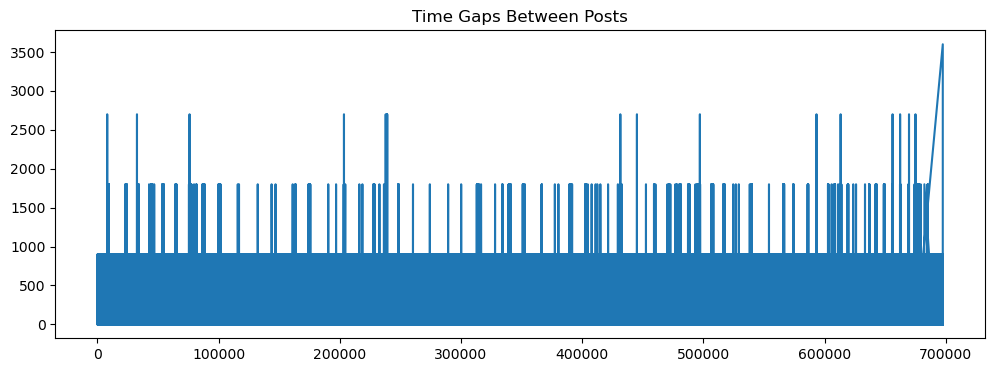

In [13]:
df_until_27thMarch_check = df_until_27thMarch.sort_values('created_at')
df_until_27thMarch_check['time_diff'] = df_until_27thMarch_check['created_at'].diff()
expected_gap = pd.Timedelta(hours=1)
breaks = df_until_27thMarch_check[df_until_27thMarch_check['time_diff'] > expected_gap]
print(breaks[['created_at', 'time_diff']])
df_until_27thMarch_check['time_diff'].dt.total_seconds().plot(figsize=(12, 4), title='Time Gaps Between Posts')

In [ ]:
# from scipy.stats import weibull_min
# import matplotlib.pyplot as plt


# # Parameters for the Weibull distribution
# k = 2.0       # shape parameter (k > 1 gives a peak)
# lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# # Determine the mode (peak) of the Weibull PDF and compute its maximum value
# x_mode = lam * ((k - 1) / k) ** (1 / k)
# max_weight = weibull_min.pdf(x_mode, k, scale=lam)

# def weight_function(x):
#     """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
#     if x < 0:
#         return 0.0
#     return weibull_min.pdf(x, k, scale=lam) / max_weight

# # Create an hourly date range for the smoothed sentiment time series
# start_time = df_until_27thMarch['created_at'].min().floor('H')
# end_time = df_until_27thMarch['created_at'].max().ceil('H')
# hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

# def compute_smoothed_sentiment_weibull(t):
#     """
#     Compute the smoothed sentiment at time t by summing the weighted sentiment scores
#     from news events in the last 48 hours.
#     """
#     # Consider news events from the past 48 hours
#     window_start = t - pd.Timedelta(hours=48)
#     df_window = df_until_27thMarch[(df_until_27thMarch['created_at'] > window_start) & (df_until_27thMarch['created_at'] <= t)]
#     if df_window.empty:
#         return 0.0
#     # Compute elapsed time in hours from each news event to time t
#     time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
#     # Calculate weights for each news event using the Weibull function
#     weights = time_diffs.apply(weight_function)
#     # Compute the weighted sum of sentiment scores
#     weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
#     return weighted_sentiment

# # Compute the smoothed sentiment for each hour in the time series
# smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
# df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# # Display the first few rows
# print(df_sentiment.head())

# # Plot the smoothed sentiment over time
# plt.figure(figsize=(12,6))
# plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
# plt.xlabel('Time')
# plt.ylabel('Smoothed Sentiment')
# plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
# plt.legend()
# plt.tight_layout()
# plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_420\1214350003.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df_until_27thMarch['created_at'].min().floor('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_420\1214350003.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df_until_27thMarch['created_at'].max().ceil('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_420\1214350003.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


NameError: name 'df_sentiment' is not defined

In [19]:
df_sentiment

,smoothed_sentiment_weibull
2024-01-01 00:00:00,0.000000
2024-01-01 01:00:00,-0.547465
2024-01-01 02:00:00,15.977209
2024-01-01 03:00:00,56.542854
2024-01-01 04:00:00,106.318283
...,...
2025-03-27 20:00:00,-100.780738
2025-03-27 21:00:00,-122.956882
2025-03-27 22:00:00,-124.954298
2025-03-27 23:00:00,-125.114529


                     smoothed_sentiment_weibull
2024-01-01 00:00:00                    0.000000
2024-01-01 01:00:00                   -0.547465
2024-01-01 02:00:00                   15.977209
2024-01-01 03:00:00                   56.542854
2024-01-01 04:00:00                  106.318283


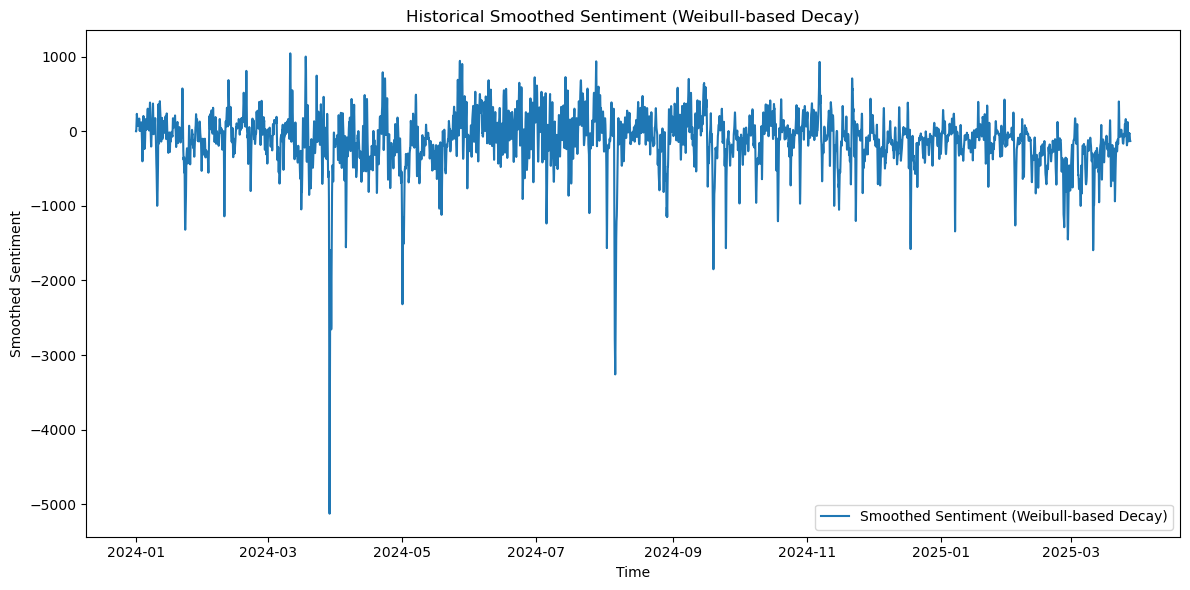

In [18]:
df_sentiment = pd.DataFrame({'smoothed_sentiment_weibull': smoothed_sentiments}, index=hourly_index)
# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mid_point = len(df) // 2
df_part1 = df_sentiment.iloc[:mid_point]
df_part2 = df_sentiment.iloc[mid_point:]

# GDELT_with_sentiment_path_part1 = os.path.join(folder_path, "GDELT_48hr_weibull_27Mar_update_part1.csv")
# GDELT_with_sentiment_path_part2 = os.path.join(folder_path, "GDELT_48hr_weibull_27Mar_update_part2.csv")

# df_part1.to_csv(GDELT_with_sentiment_path_part1)
# df_part2.to_csv(GDELT_with_sentiment_path_part2)

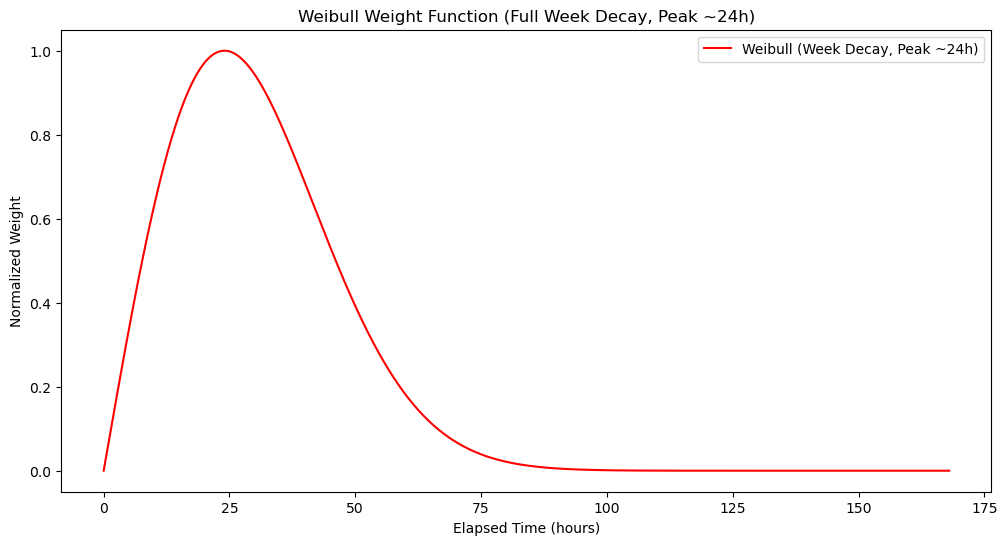

C:\Users\Justin\AppData\Local\Temp\ipykernel_22884\99487876.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df_until_4thApr['created_at'].min().floor('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_22884\99487876.py:60: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df_until_4thApr['created_at'].max().ceil('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_22884\99487876.py:61: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                     smoothed_sentiment_weibull_week
2024-01-01 00:00:00                         0.000000
2024-01-01 01:00:00                        -0.110741
2024-01-01 02:00:00                         2.833173
2024-01-01 03:00:00                        10.543272
2024-01-01 04:00:00                        21.441960
...                                              ...
2025-04-04 00:00:00                     -1751.699125
2025-04-04 01:00:00                     -1752.509797
2025-04-04 02:00:00                     -1750.695053
2025-04-04 03:00:00                     -1747.355304
2025-04-04 04:00:00                     -1741.574530

[11021 rows x 1 columns]


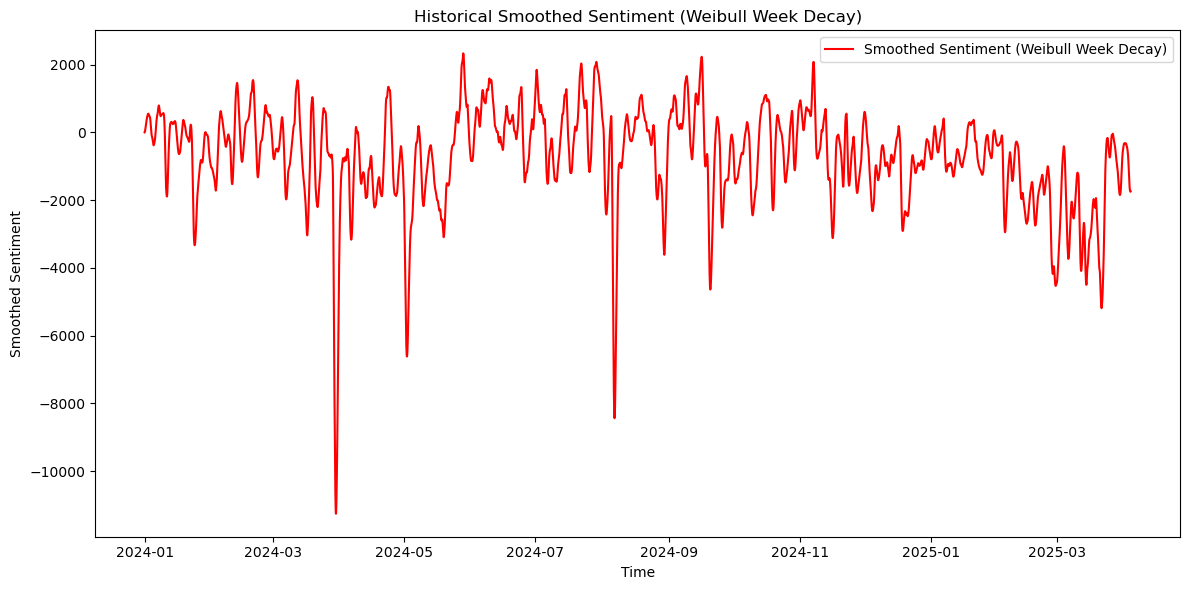

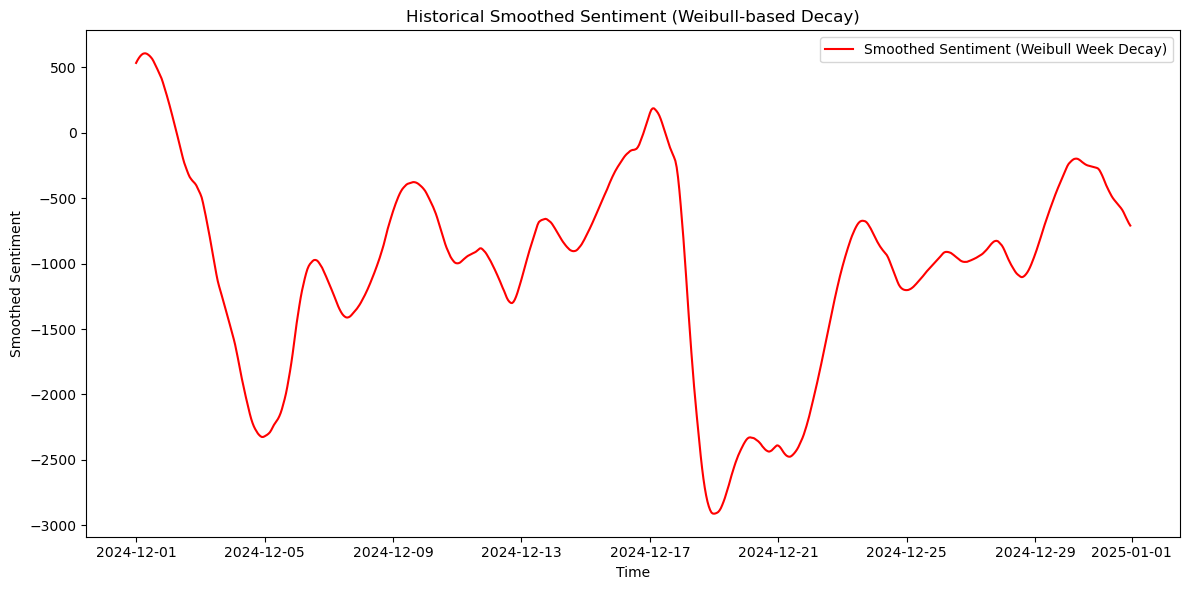

In [13]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import numpy as np

# --- Alternative Weibull Parameters for a Full Week Decay ---
# We want the mode (peak) to be ~24 hours. For a Weibull with shape k,
# the mode is given by: mode = lam * ((k-1)/k)^(1/k)
# For k = 2.0, set lam such that lam/sqrt(2) = 24 => lam = 24 * sqrt(2)
k_week = 2.0
lam_week = 24 * np.sqrt(2)   # Approximately 33.94 hours
x_mode_week = lam_week * ((k_week - 1) / k_week) ** (1 / k_week)
max_weight_week = weibull_min.pdf(x_mode_week, k_week, scale=lam_week)

def weight_function_week(x):
    """
    Compute the weight for an elapsed time x (in hours) using a Weibull PDF 
    normalized so that the maximum weight is 1.
    
    This function is designed so that the impact of a post increases to a peak 
    around 24 hours and then decays over the course of one week (168 hours).
    """
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k_week, scale=lam_week) / max_weight_week

# --- For Comparison: Plot the Weight Function ---
x_vals = np.linspace(0, 168, 500)  # from 0 to 168 hours
y_vals = [weight_function_week(x) for x in x_vals]

plt.figure(figsize=(12,6))
plt.plot(x_vals, y_vals, label='Weibull (Week Decay, Peak ~24h)', color='red')
plt.xlabel('Elapsed Time (hours)')
plt.ylabel('Normalized Weight')
plt.title('Weibull Weight Function (Full Week Decay, Peak ~24h)')
plt.legend()
plt.show()

# --- Alternative Smoothed Sentiment Function Using the New Weight Function ---
def compute_smoothed_sentiment_weibull_week(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last week (168 hours) using the alternative Weibull function.
    """
    # Consider news events in the last 168 hours (1 week)
    window_start = t - pd.Timedelta(hours=168)
    df_window = df_until_4thApr[(df_until_4thApr['created_at'] > window_start) & (df_until_4thApr['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Calculate the elapsed time in hours since each post
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Apply the alternative Weibull weight function
    weights = time_diffs.apply(weight_function_week)
    # Sum the weighted sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# --- Assuming you have start_time, end_time, and df defined ---
# For example, if:
start_time = df_until_4thApr['created_at'].min().floor('H')
end_time = df_until_4thApr['created_at'].max().ceil('H')
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

# Compute the smoothed sentiment using the alternative function
smoothed_sentiments_week = [compute_smoothed_sentiment_weibull_week(t) for t in hourly_index]

# Save results in a DataFrame for further analysis/plotting
df_sentiment = pd.DataFrame({'smoothed_sentiment_weibull_week': smoothed_sentiments_week}, index=hourly_index)
print(df_sentiment)

plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull Week Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
df_sentiment

,smoothed_sentiment_weibull_week
2024-01-01 00:00:00,0.000000
2024-01-01 01:00:00,-0.110741
2024-01-01 02:00:00,2.833173
2024-01-01 03:00:00,10.543272
2024-01-01 04:00:00,21.441960
...,...
2025-03-27 20:00:00,-201.087561
2025-03-27 21:00:00,-212.734755
2025-03-27 22:00:00,-222.298479
2025-03-27 23:00:00,-232.721356


In [14]:
mid_point = len(df) // 2
df_part1 = df_sentiment.iloc[:mid_point]
df_part2 = df_sentiment.iloc[mid_point:]

GDELT_with_sentiment_path_part1 = os.path.join(folder_path, "GDELT_week_weibull_04Apr_update_part1.csv")
GDELT_with_sentiment_path_part2 = os.path.join(folder_path, "GDELT_week_weibull_04Apr_update_part2.csv")

df_part1.to_csv(GDELT_with_sentiment_path_part1)
df_part2.to_csv(GDELT_with_sentiment_path_part2)

# PLotyt eda


In [24]:

df_until_4thApr

,created_at,sentiment_score,year,week,day
0,2024-01-01 00:00:00,NaN,2024,1,0
1,2024-01-01 00:00:00,NaN,2024,1,0
2,2024-01-01 00:00:00,NaN,2024,1,0
3,2024-01-01 00:00:00,NaN,2024,1,0
4,2024-01-01 00:15:00,NaN,2024,1,0
...,...,...,...,...,...
717725,2025-04-04 03:00:00,NaN,2025,14,4
717726,2025-04-04 03:00:00,NaN,2025,14,4
717727,2025-04-04 03:00:00,NaN,2025,14,4
717728,2025-04-04 03:15:00,NaN,2025,14,4


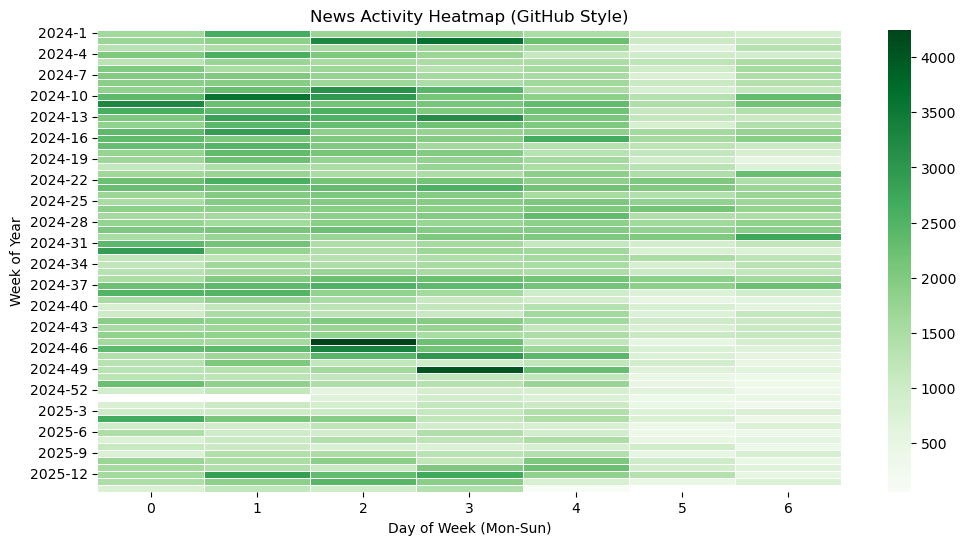

In [19]:
import seaborn as sns

df_until_4thApr['year'] = df_until_4thApr['created_at'].dt.year
df_until_4thApr['week'] = df_until_4thApr['created_at'].dt.isocalendar().week
df_until_4thApr['day'] = df_until_4thApr['created_at'].dt.dayofweek  # Monday=0, Sunday=6

heatmap_data = df_until_4thApr.groupby(['year', 'week', 'day']).size().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white")
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("News Activity Heatmap (GitHub Style)")

plt.show()

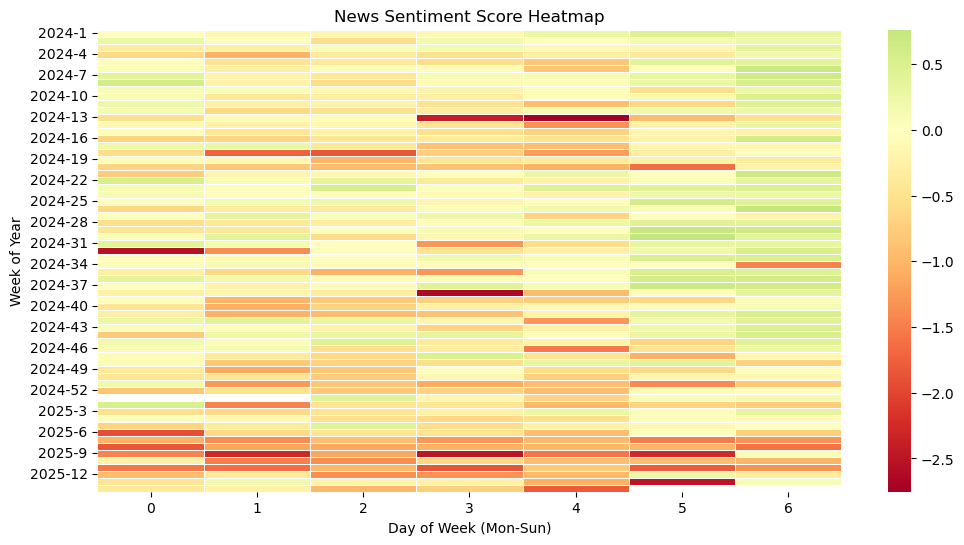

In [33]:
df_until_4thApr["created_at"] = pd.to_datetime(df_until_4thApr["created_at"])

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}

df_until_4thApr["year"] = df_until_4thApr["created_at"].dt.year
df_until_4thApr["week"] = df_until_4thApr["created_at"].dt.isocalendar().week
df_until_4thApr["day"] = df_until_4thApr["created_at"].dt.dayofweek  

heatmap_data = df_until_4thApr.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("News Sentiment Score Heatmap")
plt.show()
